# Pattern recognition - MsCV ViBOT

Guillaume Lemaitre - Fabrice Meriaudeau - Joan Massich

In [3]:

%matplotlib inline
%pprint off

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import mpld3

import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('glemaitre', 'se04g0bmi2')

import numpy as np

from scipy.io import loadmat


Pretty printing has been turned ON


## Features Extraction - Dimensionality reduction

### Principle Components Analysis (PCA) and Linear Discriminant Analysis (LDA)

In this section, we will deal with the data `data/pca_lda_data.mat`.

In [4]:

# Read the data 
data = loadmat('./data/pca_lda_data.mat')

# Extract the data
class_1 = np.asmatrix(data['class1'].T)
class_2 = np.asmatrix(data['class2'].T)
class_3 = np.asmatrix(data['class3'].T)

data = np.concatenate((class_1, class_2, class_3), axis = 0)

gt = np.ravel(np.concatenate((np.ones((np.shape(class_1)[0], 1)) * 1, np.ones((np.shape(class_2)[0], 1)) * 2, \
                     np.ones((np.shape(class_3)[0], 1)) * 3), axis = 0))


(a) Plot the data using plotly toolbox and the Scatter3d function.

In [5]:

# Define the parameters for the class #1
trace1 = Scatter3d(
    x=np.ravel(class_1[:, 0]),
    y=np.ravel(class_1[:, 1]),
    z=np.ravel(class_1[:, 2]),
    name='Class #1',
    mode='markers', marker=Marker(size=3, line=Line(color='rgba(0,0,255,1.0)', width=0.5), opacity=.8))
# Define the parameters for the class #2
trace2 = Scatter3d(
    x=np.ravel(class_2[:, 0]),
    y=np.ravel(class_2[:, 1]),
    z=np.ravel(class_2[:, 2]),
    name='Class #2',
    mode='markers', marker=Marker(size=3, symbol='diamond', line=Line(color='rgba(255,0,0,1.0)', width=0.5), opacity=.8))
# Define the parameters for the class #3
trace3 = Scatter3d(
    x=np.ravel(class_3[:, 0]),
    y=np.ravel(class_3[:, 1]),
    z=np.ravel(class_3[:, 2]),
    name='Class #3',
    mode='markers', marker=Marker(size=3, symbol='square', line=Line(color='rgba(0,255,0,1.0)', width=0.5), opacity=.8))
# Concatenate the data
plot_data = Data([trace1, trace2, trace3])
# Define the layout
layout = Layout(margin=Margin(l=0, r=0, b=0, t=0))
# Define a figure
fig = Figure(data=plot_data, layout=layout)
py.iplot(fig, filename='dataset_pca_lda')


/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:79: InsecurePlatformWarning:

A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.



#### Implementation of PCA

Implement PCA by completing the following Python code in order to return the eigenvalues and eigenvectors. Your implementation should contain the small size trick in the case that it will be necessary. To do so, we will decompose the problem in different steps:

##### Mean invariance

(a) Complete the following function by:

* Computing the mean of the data for each feature dimension => Use np.mean() with the argument axis,
* Return the original data subtracted by its mean vector.

In [6]:

# Define a function to obtain mean invariance
def MeanInvariance(X):
    # Compute the mean vector
    ### Use the function np.mean() with the axis argument
    mean_data = np.mean(X, axis = 1)
    
    # Subtract the mean vector and return the matrix
    return X - mean_data
    

##### PCA decomposition

(b) Complete the following function in order to obtain the eigenvalues and eigenvectors. This function neglecte the small size trick. To do so, you will need to:

* Compute the covariance matrix $C = XX^t$ and normalise $C$ by the number of feature dimensions.
* Compute the eigenvectors $V$ with its corresponding eigenvalues $\lambda$ => Use np.linalg.eig(),
* Transorm the eigenvalues and eigenvectors array to be considered as a 2-D array => Use np.atleast_2d(),
* Return the eigenvectors and eigenvalues.

In [7]:

# Define a function to obtain the eigen decomposition as in the original PCA
def NormalDecompositionPCA(X):
    # Compute the covariance matrix with the size trick
    C = (X * X.T) / (float(np.shape(X)[0]) - 1.)
    
    # Compute the eigenvalues and eigenvectors of C
    w, v = np.linalg.eig(C)
    w = np.atleast_2d(w)
    v = np.atleast_2d(v)
    
    return (w, v)


##### Small size trick decomposition

(c) Complete the following Python function, to implement the small size trick. To do so, you will need to:

* Transpose the data vector,
* Apply normal PCA,
* Change the eigenvectors $V'$ such that $V = XV'$,
* Return the eigenvectors and eigenvalues.

In [8]:

# Define a function to obtain the eigen decomposition as in the original PCA
def SmallSizeTrickDecompositionPCA(X):
        # Apply PCA by transposing the data
        w, v = NormalDecompositionPCA(X.T)
        
        # Recompute the eigenvector for the original data
        v = X * v
        
        return (w, v)
    

##### Put it all together ...

(d) Complete the following all together to get the PCA.

In [9]:

# Implement PCA returning the eigenvectors and eigenvalues
### data should be N x L with N the number of samples and L the number of feature dimensions
def PCAPr(X):
    
    # NOTE: Transpose the data in order to obtain an LxN matrix as the PCA convention
    # Apply the mean invariance
    data_pca = MeanInvariance(X.T)
    
    # Check if we apply the small size trick or not
    ### Apply small trick
    if (np.shape(data_pca)[0] > np.shape(data_pca)[1]):
        return SmallSizeTrickDecompositionPCA(data_pca)    
    ### Normal PCA
    else:
        return NormalDecompositionPCA(data_pca)


##### Dimension reduction

The projection of the data to a lower space using the eigenvalues and eigenvectors is similiar for PCA and LDA. Thus, you will create a specific function in order to handle this projection.

(a) Complete the following function in order to project the data into a space with a lower dimensionality. To do so, you will have to:

* Sort the eigenvectors depending of the eigenvalues => Use np.argsort(),
* Return the projected data $X_r = X V_i$ where $V_i$ are the $i^{\text{th}}$ first eigenvectors.

In [10]:

# Decomposition using PCA
### data should be N x L with N the number of samples and L the number of feature dimensions
def ProjectionData(X, v, w, nb_component = 1):
    
    if nb_component > np.shape(X)[1]:
        raise NameError('The number of component cannot be higher than the inital number of dimensions of X. \
        We do dimensionality reduction here!!!!!')
    
    # Start by sorting the eigenvalues and eigenvectors based on the eigenvalues
    ### Find the sorting index using np.argsort()
    idx_sorted = np.ravel(np.argsort(w))[::-1]
    
    # Re-order eigenvalues and eigenvector
    w = w[:, idx_sorted]
    v = v[:, idx_sorted]
    
    return (X * v[:, 0 : nb_component])
    

##### Apply PCA and dimension reduction

(a) Apply PCA and the dimension reduction for each class, plot the distribution of each class.

In [11]:

# Apply PCA
eigw, eigv = PCAPr(data)

# Apply the projection of the data
class_1_pca = ProjectionData(class_1, eigv, eigw)
class_2_pca = ProjectionData(class_2, eigv, eigw)
class_3_pca = ProjectionData(class_3, eigv, eigw)


(b) Plot the distribution of the different once projected in the low dimensional space.

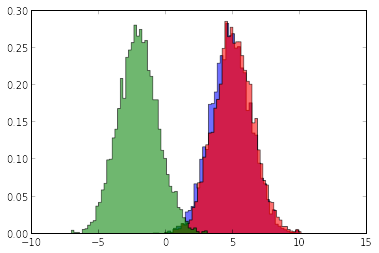

In [15]:

# Plot the different class
nb_bins = 50

fig = plt.figure()
# Distribution of the projection of the class #1 
n, bins, patches = plt.hist(class_1_pca, nb_bins, normed=1, histtype='stepfilled', label='Class #1')
plt.setp(patches, 'facecolor', 'b', 'alpha', 0.75)
# Distribution of the projection of the class #1
n, bins, patches = plt.hist(class_2_pca, nb_bins, normed=1, histtype='stepfilled', label='Class #2')
plt.setp(patches, 'facecolor', 'r', 'alpha', 0.75)
# Distribution of the projection of the class #1
n, bins, patches = plt.hist(class_3_pca, nb_bins, normed=1, histtype='stepfilled', label='Class #3')
plt.setp(patches, 'facecolor', 'g', 'alpha', 0.75)
#plt.legend(framealpha=0)
plt.show()

#### Implementation of PCA in scikit-learn toolbox

As reference, we give an example of how to use PCA implemented in scikit-learn.

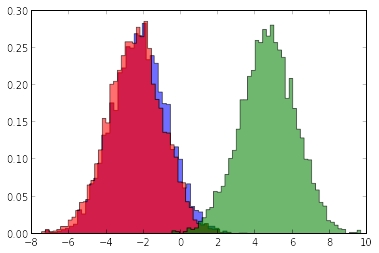

In [16]:

from sklearn.decomposition import PCA

pca_data = PCA(n_components = 1)
pca_data.fit(data)

class_1_pca = pca_data.transform(class_1)
class_2_pca = pca_data.transform(class_2)
class_3_pca = pca_data.transform(class_3)

# Plot the different class
nb_bins = 50

fig = plt.figure()
# Distribution of the projection of the class #1 
n, bins, patches = plt.hist(class_1_pca, nb_bins, normed=1, histtype='stepfilled', label='Class #1')
plt.setp(patches, 'facecolor', 'b', 'alpha', 0.75)
# Distribution of the projection of the class #1
n, bins, patches = plt.hist(class_2_pca, nb_bins, normed=1, histtype='stepfilled', label='Class #2')
plt.setp(patches, 'facecolor', 'r', 'alpha', 0.75)
# Distribution of the projection of the class #1
n, bins, patches = plt.hist(class_3_pca, nb_bins, normed=1, histtype='stepfilled', label='Class #3')
plt.setp(patches, 'facecolor', 'g', 'alpha', 0.75)
#plt.legend(framealpha=0)
plt.show()


#### Implementation of LDA

LDA differs from PCA since that it is taking into account the classes properties. Thus, we defined the following Python class `pr_class` which will be used in LDA. The class `pr_class` is characterized by the following attributes:

* `n_dims`: corresponds to the number of feature dimensions,
* `n_samples`: corresponds to the number of samples,
* `data`: a matrix with the entire data od size `n_samples` by `n_dims`,
* `gt`: a vector with the ground-truth labels,
* `mean_vec`: a vector with the mean of each feature dimension,
* `cov_matrix`: a matrix containing the covariance of `data`.
* `prior`: a scalar with the prior of the class.

In [18]:

# Define a class for all the information
class pr_class(object):     
    def __init__(self, X, y, prior):
        self.n_dims = np.shape(X)[1]
        self.n_samples = np.shape(X)[0]
        self.data = X
        self.gt = y
        self.mean_vec = np.mean(X, axis = 0)
        self.cov_mat = (self.data - self.mean_vec).T * (self.data - self.mean_vec) / (float(self.n_samples) - 1.)
        self.prior = prior
        

As for PCA, the implementation of LDA will be broken down in several steps.

##### Creation of a list of `pr_class` containing each class information

We first need to split the data by classes and compute the mean and covariance by calling the constructor of the class `pr_class`.

In [19]:

# Define a function to build a list (or vector) of pr_class
def BuildListClass(X, y, priors):
    # Find the number of classes
    nb_classes = np.size(np.unique(y))
    
    # Create an object for each class
    return [pr_class(X[np.ravel(np.nonzero(y == (np.unique(y)[count]))), :], \
                     y[np.ravel(np.nonzero(y == (np.unique(y)[count])))], \
                     priors[count]) for count in xrange(nb_classes)]


##### With-in class scatter matrix

(a) Complete the following code to compute the with-in class scatter matrix. Thus, make the sum of the covariance of each class normalized by their prior.

In [20]:

# Define a function to compute the with-in class scatter matrix
### X is the list of `pr_class`
def ComputeSw(X):
    Sw = 0.
    for c in range(0, np.size(X)):
        Sw += X[c].prior * X[c].cov_mat
        
    return Sw

##### Between classes scatter matrix

(b) Complete the following code to compute the between classes scatter matrix. To do so, you will need to:

* Concatenate all the data inside a matrix,
* Compute the sum of the covariances which are the differences between the mean of each class and the total mean.

In [21]:

# Define a function to compute the between classes scatter matrix
### X is the list of `pr_class`
def ComputeSb(X):
    # Concatenate all the data to get the mixture covariance
    all_data = np.squeeze([X[count].data for count in xrange(np.size(X))])
    all_data = np.concatenate([all_data[count] for count in xrange(np.shape(all_data)[0])], axis=0)
    
    Sb = 0.
    for c in range(0, np.size(X)):
        Sb += X[c].prior * ((X[c].mean_vec - np.mean(all_data, axis = 0)).T * (X[c].mean_vec - np.mean(all_data, axis = 0)))
    
    return Sb

##### Put it all together ...

(a) Complete the following function to implement LDA. To do so,

* Construct a list of `pr_class`,
* Compute the scatter matrix $S$ such as $S = \frac{S_b}{S_w}$,
* Apply the eigen decomposition of $S$,
* Return the eigenvalues and eigenvectors.

In [22]:

# Definition of LDA
def LDAPr(X, y, priors):
   
    # Build the list of classes
    classes_pr = BuildListClass(X, y, priors)
    
    # Compute the matrix for subsequent decomposition
    S = ComputeSb(classes_pr) / ComputeSw(classes_pr)
    
    # Compute the eigenvalues and eigenvectors of C
    w, v = np.linalg.eig(S)
    w = np.atleast_2d(w)
    v = np.atleast_2d(v)
   
    return (w, v)

##### Apply LDA and dimension reduction

(a) Apply LDA and the dimension reduction for each class, plot the distribution of each class.

In [23]:

# Apply LDA
eigw, eigv = LDAPr(data, gt, np.ravel(np.ones((np.size(np.unique(gt)),)) / float(np.size(np.unique(gt)))))

# Compute the projection of the data
class_1_lda = ProjectionData(class_1, eigv, eigw)
class_2_lda = ProjectionData(class_2, eigv, eigw)
class_3_lda = ProjectionData(class_3, eigv, eigw)


(b) Plot the distribution of the different once projected in the low dimensional space.

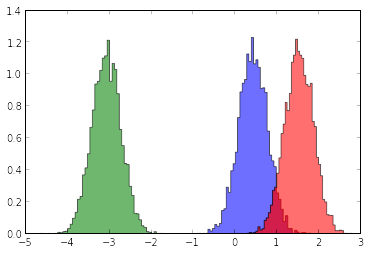

In [25]:

# Plot the different class
nb_bins = 50

# Plot the different class
nb_bins = 50

fig = plt.figure()
# Distribution of the projection of the class #1 
n, bins, patches = plt.hist(class_1_lda, nb_bins, normed=1, histtype='stepfilled', label='Class #1')
plt.setp(patches, 'facecolor', 'b', 'alpha', 0.75)
# Distribution of the projection of the class #1
n, bins, patches = plt.hist(class_2_lda, nb_bins, normed=1, histtype='stepfilled', label='Class #2')
plt.setp(patches, 'facecolor', 'r', 'alpha', 0.75)
# Distribution of the projection of the class #1
n, bins, patches = plt.hist(class_3_lda, nb_bins, normed=1, histtype='stepfilled', label='Class #3')
plt.setp(patches, 'facecolor', 'g', 'alpha', 0.75)
#plt.legend(framealpha=0)
plt.show()


#### Implementation of LDA in scikit-learn toolbox

As reference, we give an example of how to use LDA implemented in scikit-learn.

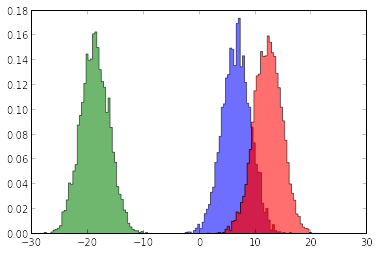

In [27]:

# Import LDA from scikit-learn
from sklearn.lda import LDA

# Project using LDA
lda = LDA(n_components=1)
lda.fit(data, gt)

class_1_lda = lda.transform(class_1)
class_2_lda = lda.transform(class_2)
class_3_lda = lda.transform(class_3)

# Plot the different class
nb_bins = 50

# Plot the different class
nb_bins = 50

fig = plt.figure()
# Distribution of the projection of the class #1 
n, bins, patches = plt.hist(class_1_lda, nb_bins, normed=1, histtype='stepfilled', label='Class #1')
plt.setp(patches, 'facecolor', 'b', 'alpha', 0.75)
# Distribution of the projection of the class #1
n, bins, patches = plt.hist(class_2_lda, nb_bins, normed=1, histtype='stepfilled', label='Class #2')
plt.setp(patches, 'facecolor', 'r', 'alpha', 0.75)
# Distribution of the projection of the class #1
n, bins, patches = plt.hist(class_3_lda, nb_bins, normed=1, histtype='stepfilled', label='Class #3')
plt.setp(patches, 'facecolor', 'g', 'alpha', 0.75)
#plt.legend(framealpha=0)
plt.show()


### To take away ...

(a) Explain in few lines the difference between PCA and LDA. 

PCA allows to make an analysis on the variance of the data as a whole while LDA take into account the each class.

(b) Explain the difference between features selection and features extraction.

Features selection corresponds to select a subset of features dimensions which usually are the most discriminative. With the features extraction, the data are projected into a new space which can also has a reduced a number of features dimensions. However, the features space is different from the original space due to the projection.